In [11]:
import numpy as np
from utils_clean import generate_sample, DEOptim, RandomOptim, PSOOptim, visualize_meshgrid, get_likelihood_grids, visualize_pred_meshgrid
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
dimensions = [3, 10, 15, 25, 35, 40, 45, 50]
target_func = lambda X: (20 + X**2 - 10 * np.cos(2*np.pi*X)).sum(axis=0)
results_thetas_per_dims = {}
results_logMargLikeli_pso = {}
results_mse_per_dims = {}
results_r2_per_dims = {}
results_mape_per_dims = {}
results_thetas_de = {}
results_logMargLikeli_de = {}
results_thetas_rs = {}
results_logMargLikeli_rs = {}

for d in dimensions:
    lower_bound = (-2.5,) * d
    upper_bound = (+1.5,) * d

    X, y = generate_sample(70, d, lower_bound, upper_bound, target_func)

    seed = np.random.RandomState(42)
    part = 10
    dim = d
    pso = PSOOptim(n_iters=100, n_particles=part, c1=0.5, c2=0.3, w=0.9, init_pos=(seed.rand(part, dim)*22)-11, visualize=True)
    gpr_pso = GaussianProcessRegressor(optimizer=pso.optimize, kernel=RBF(length_scale=(1,) * d))
    gpr_pso.fit(X.T, y[...,None])
    y_pred = gpr_pso.predict(X.T) 
    results_logMargLikeli_pso[d] = gpr_pso.log_marginal_likelihood_value_

    de = DEOptim()
    gpr_de = GaussianProcessRegressor(optimizer=de.optimize, kernel=RBF(length_scale=(1,)*d))
    gpr_de.fit(X.T, y[...,None])
    y_pred = gpr_de.predict(X.T)

    results_thetas_de[d] = gpr_de.kernel_.theta
    results_logMargLikeli_de[d] = gpr_de.log_marginal_likelihood_value_

    rs = RandomOptim(maxiter=1000, visualize=True)
    gpr_rs = GaussianProcessRegressor(optimizer=rs.optimize, kernel=RBF(length_scale=(1,)*d))
    gpr_rs.fit(X.T, y[...,None])
    y_pred = gpr_rs.predict(X.T)

    results_thetas_rs[d] = gpr_de.kernel_.theta
    results_logMargLikeli_rs[d] = gpr_de.log_marginal_likelihood_value_

    results_thetas_per_dims[d] = gpr_pso.kernel_.theta
    results_logMargLikeli_pso[d] = gpr_pso.log_marginal_likelihood_value_
    results_mse_per_dims[d] = mean_squared_error(y, y_pred)
    results_r2_per_dims[d] = r2_score(y, y_pred)
    results_mape_per_dims[d] = mean_absolute_percentage_error(y, y_pred)

2022-08-10 09:30:48,009 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=6.22e+4
2022-08-10 09:30:49,502 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 62246.61729203696, best pos: [ 0.31427852 -0.0067986  -1.29943892]
2022-08-10 09:30:51,271 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.01e+5
2022-08-10 09:30:53,157 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 300787.9629294226, best pos: [4.62610861 2.07515956 0.18735384 1.54452256 0.6649851  1.81108204
 0.61141766 0.69207733 7.55577855 1.62370847]
2022-08-10 09:30:58,520 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.59e+6
2022-08

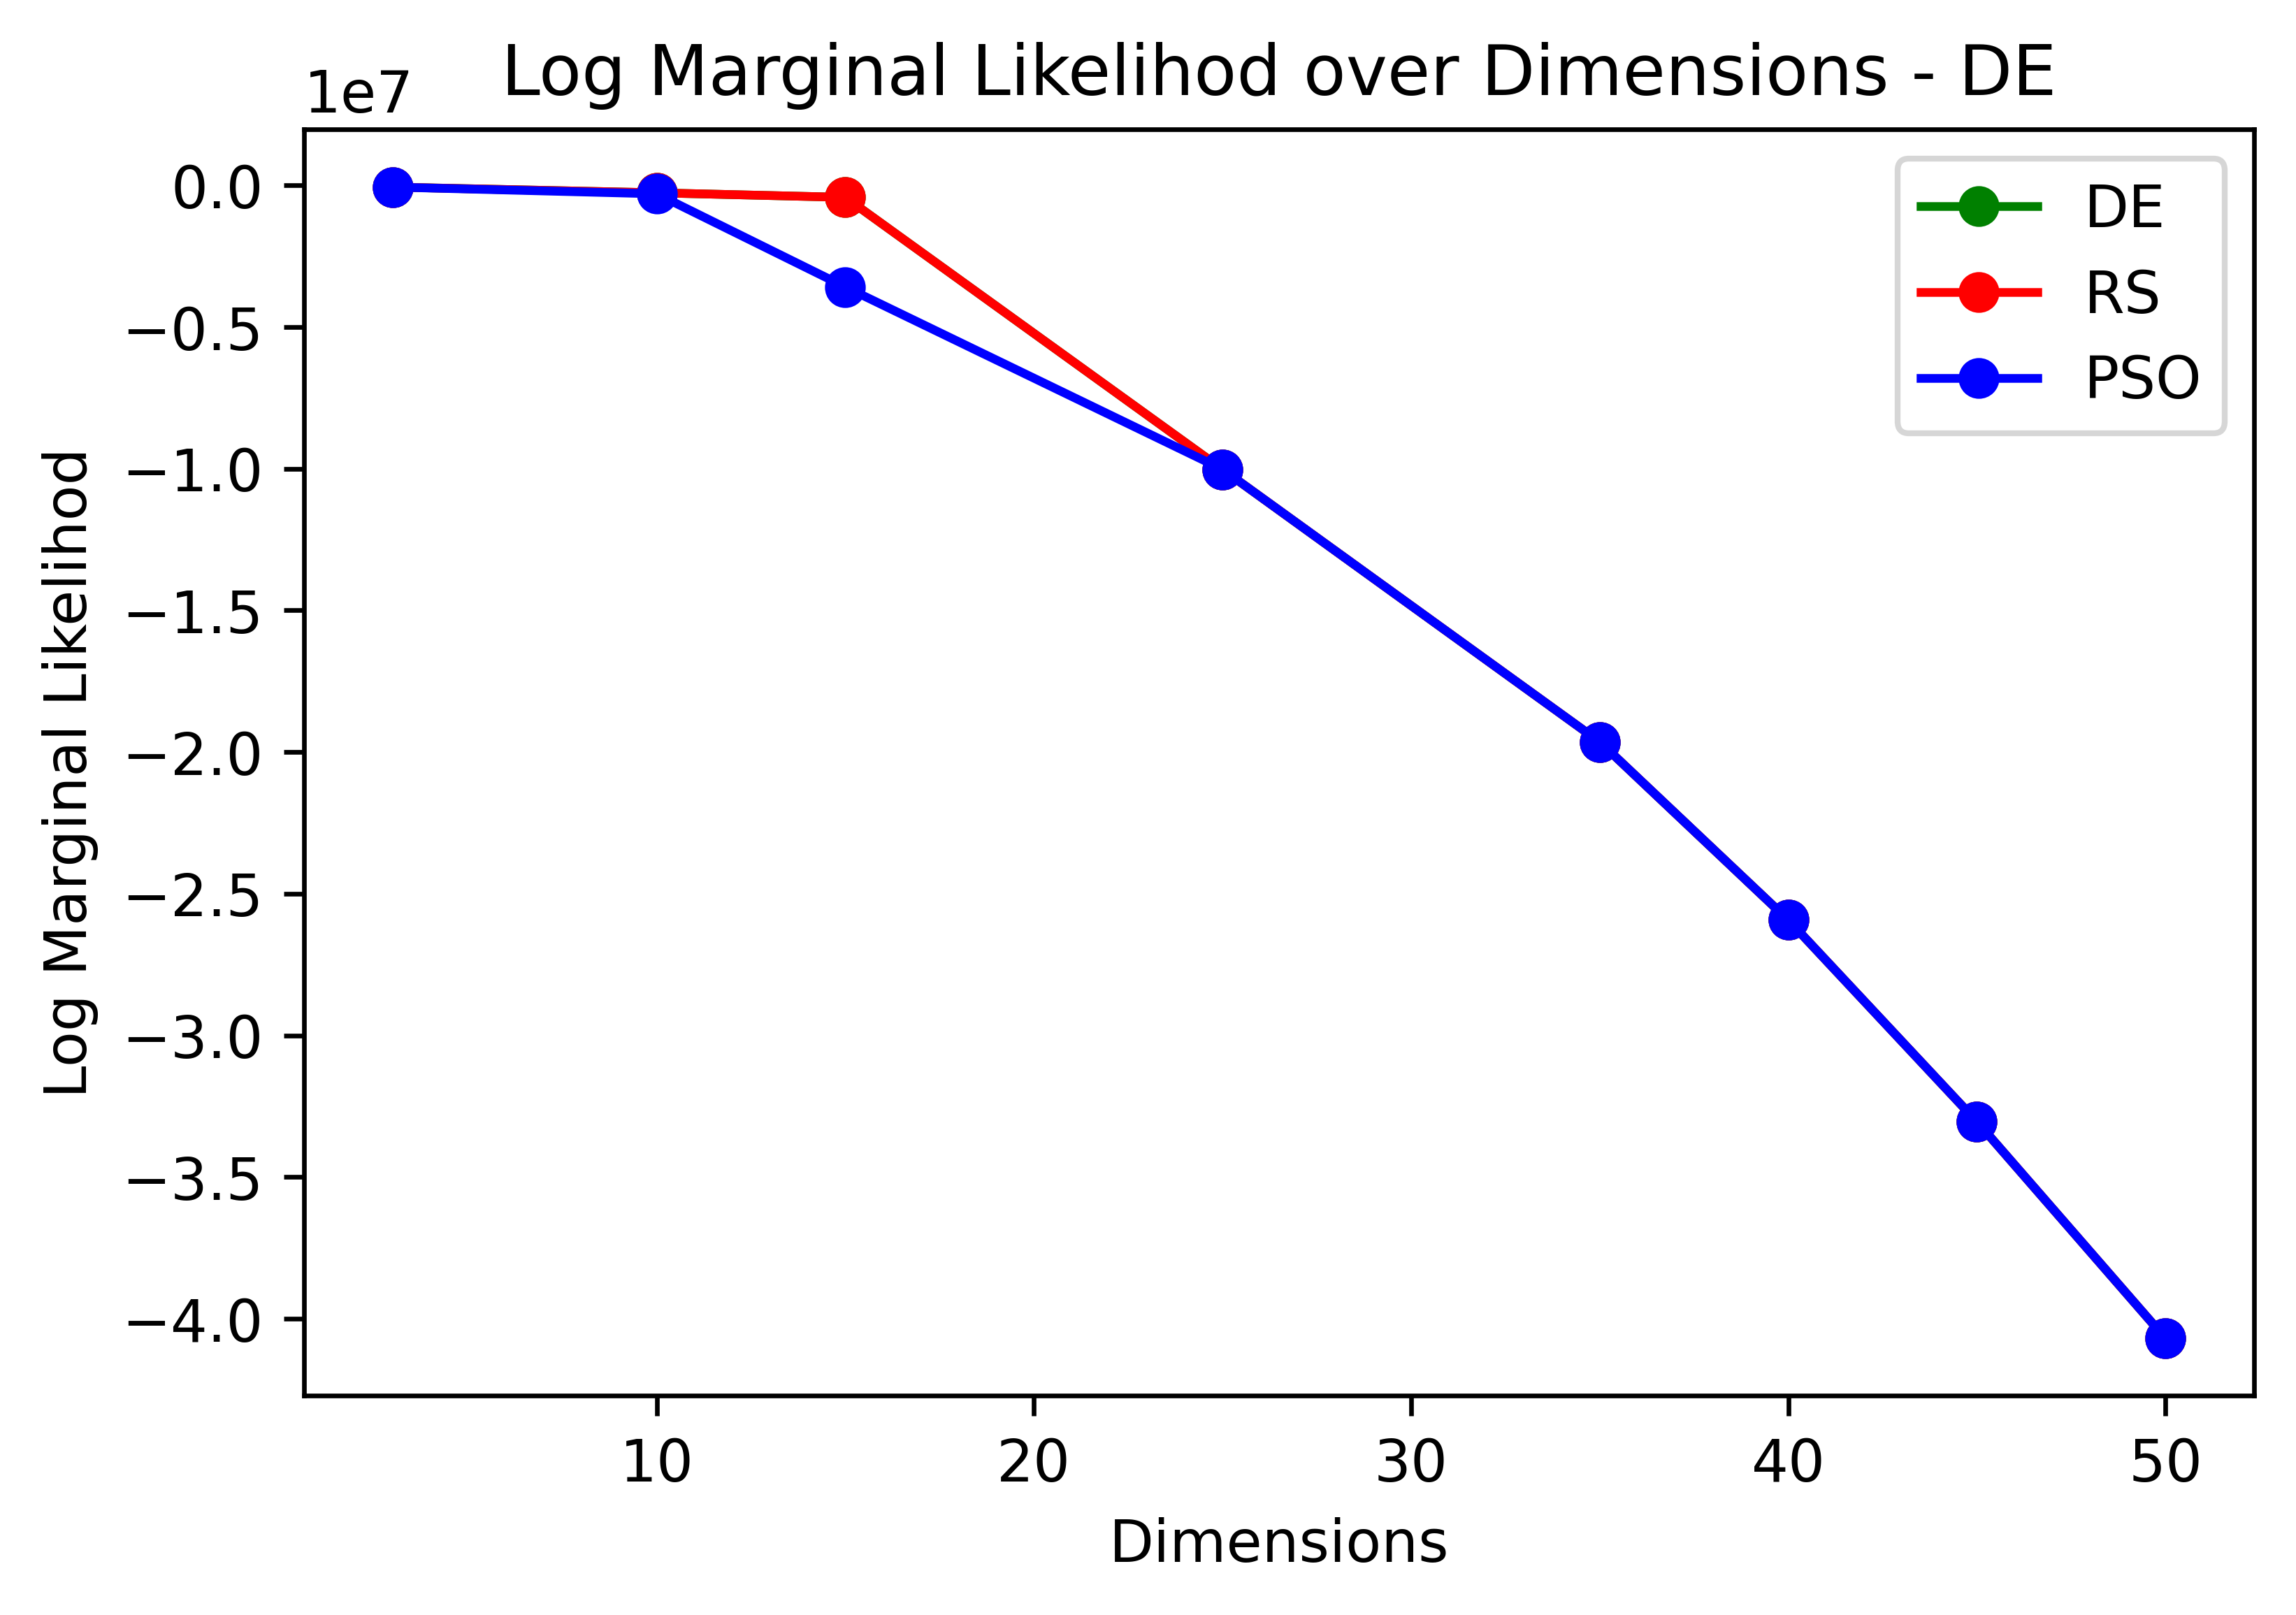

In [13]:
X_plot = results_logMargLikeli_de.keys()
fig = plt.figure(dpi=600)
plt.plot(X_plot, results_logMargLikeli_de.values(), marker='o', label="DE", color="g")
plt.plot(X_plot, results_logMargLikeli_rs.values(), marker='o', label="RS", color="r")
plt.plot(X_plot, results_logMargLikeli_pso.values(), marker='o', label="PSO", color="b")
plt.title("Log Marginal Likelihod over Dimensions - DE")
plt.xlabel("Dimensions")
plt.ylabel("Log Marginal Likelihod ")
plt.legend()
plt.show()

In [14]:
df_results = pd.DataFrame({"Iteration":[], "Dimension":[], "DE_ML":[], "PSO_ML":[], "RS_ML":[]})

In [15]:
dimensions = [5, 10, 15, 20]
target_func = lambda X: (20 + X**2 - 10 * np.cos(2*np.pi*X)).sum(axis=0)
results_logMargLikeli_per_dims = {}
results_logMargLikeli_de = {}
results_logMargLikeli_rs = {}

for i in range(20):
    for d in dimensions:
        seed = np.random.RandomState(i)
        lower_bound = (-2.5,) * d
        upper_bound = (+1.5,) * d

        X, y = generate_sample(70, d, lower_bound, upper_bound, target_func)

        part = 10
        dim = d
        pso = PSOOptim(n_iters=100, n_particles=part, c1=0.5, c2=0.3, w=0.9, init_pos=(seed.rand(part, dim)*22)-11, visualize=True)
        gpr_pso = GaussianProcessRegressor(optimizer=pso.optimize, kernel=RBF(length_scale=(1,) * d))
        gpr_pso.fit(X.T, y[...,None])
        
        optim = DEOptim()
        gpr_de = GaussianProcessRegressor(optimizer=optim.optimize, kernel=RBF(length_scale=(1,)*d))
        gpr_de.fit(X.T, y[...,None])
      
        rs = RandomOptim(maxiter=1000, visualize=True, random_state=i)
        gpr_rs = GaussianProcessRegressor(optimizer=rs.optimize, kernel=RBF(length_scale=(1,)*d))
        gpr_rs.fit(X.T, y[...,None])
       
        df_results.loc[len(df_results)] = [i, d, gpr_de.log_marginal_likelihood_value_, gpr_pso.log_marginal_likelihood_value_, gpr_rs.log_marginal_likelihood_value_]
    

2022-08-10 09:32:37,387 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=1.02e+5
2022-08-10 09:32:40,190 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 102317.12192053805, best pos: [ 1.40275816  0.25277557 -0.17416235  0.92415659  0.16225957]
2022-08-10 09:32:42,376 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.11e+5
2022-08-10 09:32:43,666 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 311353.24600638554, best pos: [0.54470538 7.73425103 5.16625962 4.02542739 0.23893274 0.67396908
 0.62472242 1.46752402 2.41474384 1.24474831]
2022-08-10 09:32:47,221 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100,

In [16]:
df_results["Iteration"] = df_results["Iteration"].astype(int)
df_results
df_results.to_csv("DimensionData.csv",index=False)

In [17]:
df_1 = df_results[["Dimension","DE_ML"]]
df_1["Optimizer"] = "DE"
df_1=df_1.rename(columns={"DE_ML": "Log Likelihood"}, inplace=False)
df_2 = df_results[["Dimension","PSO_ML"]]
df_2["Optimizer"] = "PSO"
df_2=df_2.rename(columns={"PSO_ML": "Log Likelihood"}, inplace=False)
df_3 = df_results[["Dimension","RS_ML"]]
df_3["Optimizer"] = "RS"
df_3=df_3.rename(columns={"RS_ML": "Log Likelihood"}, inplace=False)

C:\Users\Pascal\AppData\Local\Temp\ipykernel_10448\2423643525.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1["Optimizer"] = "DE"
C:\Users\Pascal\AppData\Local\Temp\ipykernel_10448\2423643525.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["Optimizer"] = "PSO"
C:\Users\Pascal\AppData\Local\Temp\ipykernel_10448\2423643525.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [18]:
df_results_ = pd.concat((df_1, df_2, df_3))
df_results_

,Dimension,Log Likelihood,Optimizer
0,5.0,-1.339034e+05,DE
1,10.0,-2.437875e+05,DE
2,15.0,-3.587482e+06,DE
3,20.0,-6.437604e+06,DE
4,5.0,-1.022497e+05,DE
...,...,...,...
75,20.0,-6.437239e+06,RS
76,5.0,-1.422706e+05,RS
77,10.0,-4.282240e+05,RS
78,15.0,-3.524013e+06,RS


In [ ]:
}
i= 0
plt.figure(figsize=(12,4), dpi=600)
for f in f_list:
    i+=1
    plt.subplot(1,3,i)
    ax = sns.boxplot(x="Optimizer", y="Log Likelihood", data=df_results_.loc[df_results["Groundtruth"]==f], color="white", linewidth=1.2, flierprops = dict(markerfacecolor='black', markersize=8,
                  markeredgecolor='none'), **PROPS)
    plt.title(f'${f}$')
plt.tight_layout()

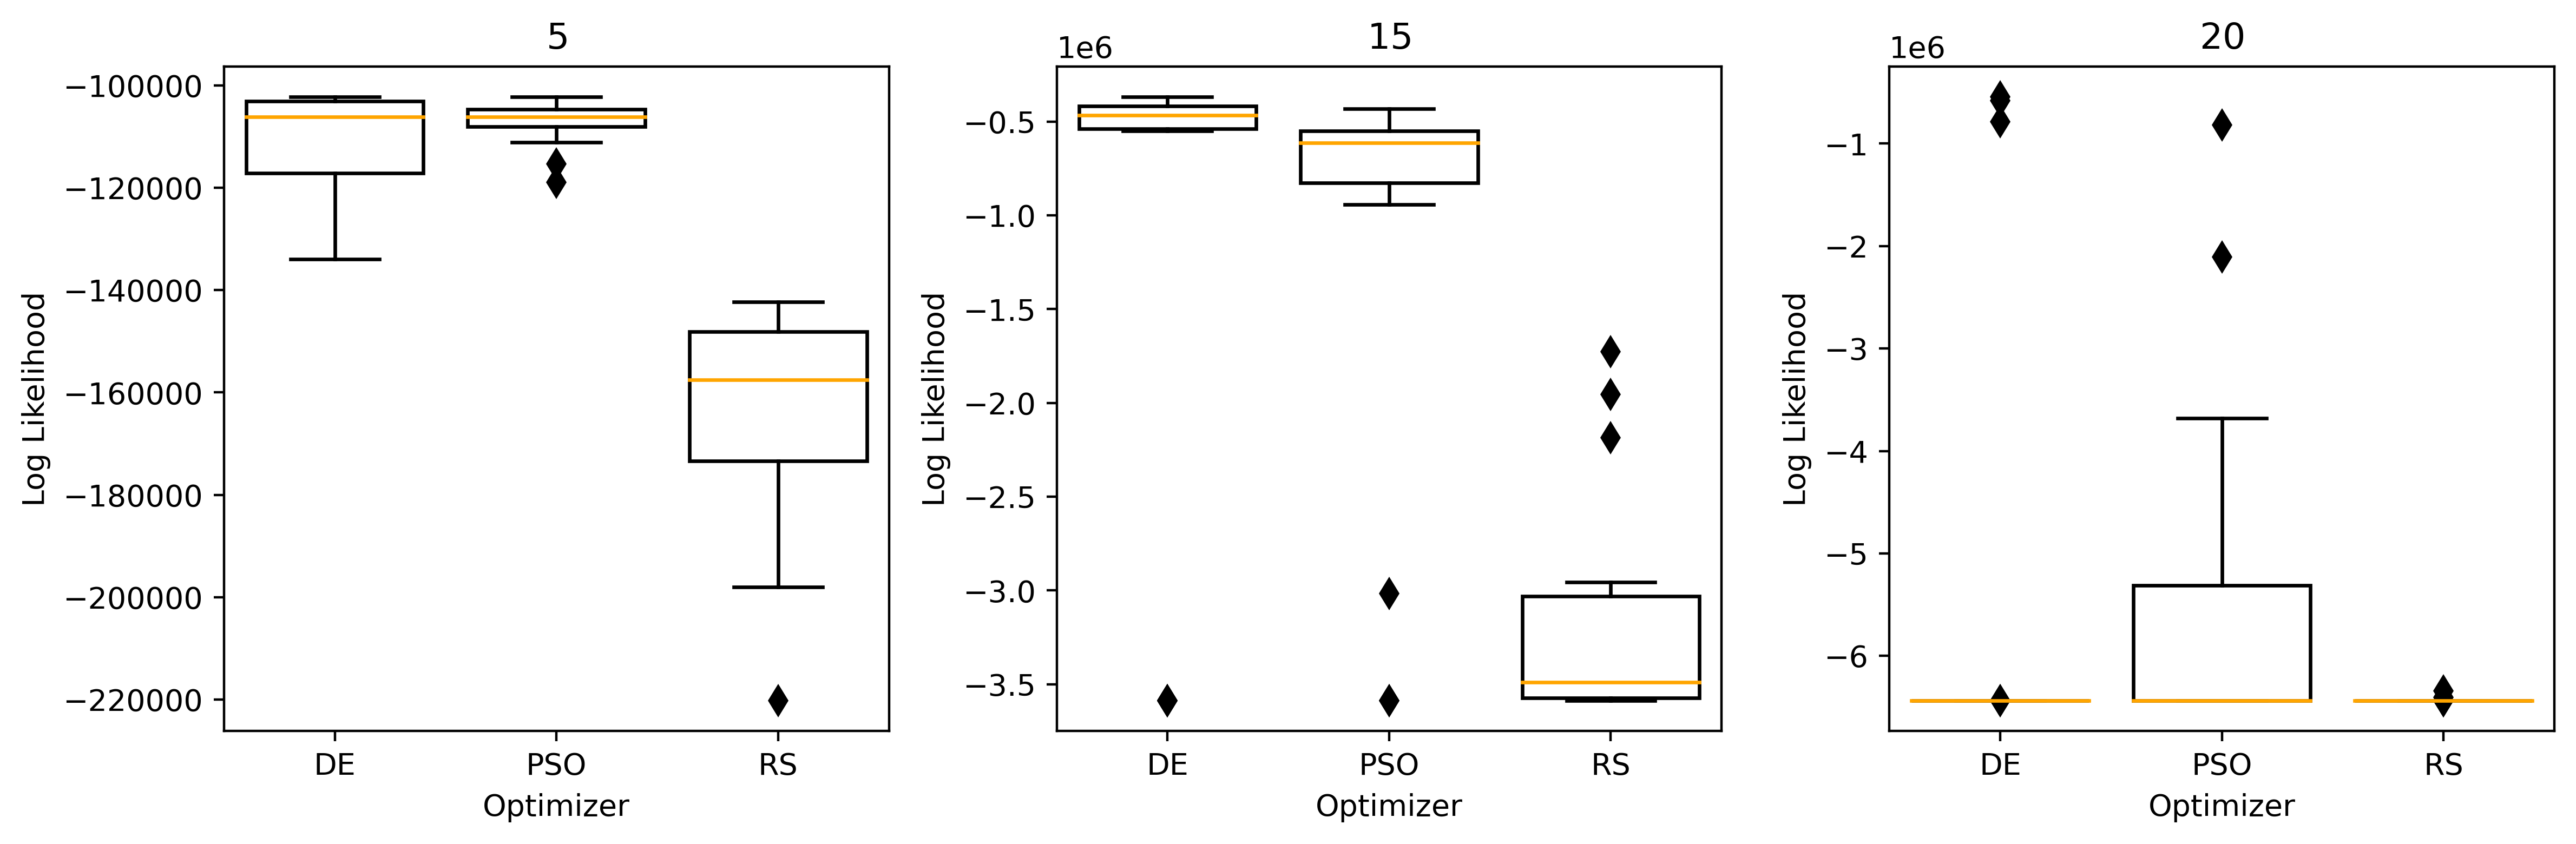

In [33]:
import seaborn as sns

if 10 in dimensions:
    dimensions.remove(10)

PROPS = {'boxprops':{'facecolor': "white", 'edgecolor':'black'},
'medianprops':{'color':'orange'},
'whiskerprops':{'color':'black'},
'capprops':{'color':'black'}
}
i= 0
plt.figure(figsize=(12,4), dpi=400)
for f in dimensions:
    i+=1
    plt.subplot(1,3,i)
#     if i != 0:
#             plt.subplot(1,4,i+1, sharey=ax)
#     else:
#             plt.subplot(1,4,i+1)
    ax = sns.boxplot(x="Optimizer", y="Log Likelihood", data=df_results_.loc[df_results["Dimension"]==f], color="white", linewidth=1.2, flierprops = dict(markerfacecolor='black', markersize=8,
                  markeredgecolor='none'), **PROPS)
   
    plt.title(f'${f}$')
plt.tight_layout()

In [20]:
std_mean_results = df_results_.groupby(["Dimension", "Optimizer"], as_index=False).agg({'Log Likelihood':['mean','std']})


In [21]:
std_mean_results

Dimension Optimizer Log Likelihood              
                                 mean           std
0        5.0        DE  -1.104184e+05  9.541108e+03
1        5.0       PSO  -1.070844e+05  4.222354e+03
2        5.0        RS  -1.643764e+05  2.049396e+04
3       10.0        DE  -2.590575e+05  2.805486e+04
4       10.0       PSO  -3.506669e+05  2.980082e+05
5       10.0        RS  -5.979373e+05  1.281385e+05
6       15.0        DE  -1.076919e+06  1.288952e+06
7       15.0       PSO  -1.032761e+06  1.033242e+06
8       15.0        RS  -3.197962e+06  5.766993e+05
9       20.0        DE  -5.567497e+06  2.125494e+06
10      20.0       PSO  -5.600793e+06  1.612876e+06
11      20.0        RS  -6.431317e+06  2.189631e+04

In [22]:
DE_results = std_mean_results.loc[std_mean_results['Optimizer'] == "DE"]
RS_results = std_mean_results.loc[std_mean_results['Optimizer'] == "RS"]
PSO_results = std_mean_results.loc[std_mean_results['Optimizer'] == "PSO"]

In [23]:
from scipy.stats import t
DE_results["conf_95_o"] = t.ppf((1+0.95)/2., 20-1) * DE_results["Log Likelihood"]["std"] + DE_results["Log Likelihood"]["mean"]
DE_results["conf_95_u"] = -t.ppf((1+0.95)/2., 20-1) * DE_results["Log Likelihood"]["std"] + DE_results["Log Likelihood"]["mean"]

RS_results["conf_95_o"] = t.ppf((1+0.95)/2., 20-1) * RS_results["Log Likelihood"]["std"] + RS_results["Log Likelihood"]["mean"]
RS_results["conf_95_u"] = -t.ppf((1+0.95)/2., 20-1) * RS_results["Log Likelihood"]["std"] + RS_results["Log Likelihood"]["mean"]

PSO_results["conf_95_o"] = t.ppf((1+0.95)/2., 20-1) * PSO_results["Log Likelihood"]["std"] + PSO_results["Log Likelihood"]["mean"]
PSO_results["conf_95_u"] = -t.ppf((1+0.95)/2., 20-1) * PSO_results["Log Likelihood"]["std"] + PSO_results["Log Likelihood"]["mean"]

C:\Users\Pascal\AppData\Local\Temp\ipykernel_10448\1671422384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DE_results["conf_95_o"] = t.ppf((1+0.95)/2., 20-1) * DE_results["Log Likelihood"]["std"] + DE_results["Log Likelihood"]["mean"]
C:\Users\Pascal\AppData\Local\Temp\ipykernel_10448\1671422384.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DE_results["conf_95_u"] = -t.ppf((1+0.95)/2., 20-1) * DE_results["Log Likelihood"]["std"] + DE_results["Log Likelihood"]["mean"]
C:\Users\Pascal\AppData\Loc

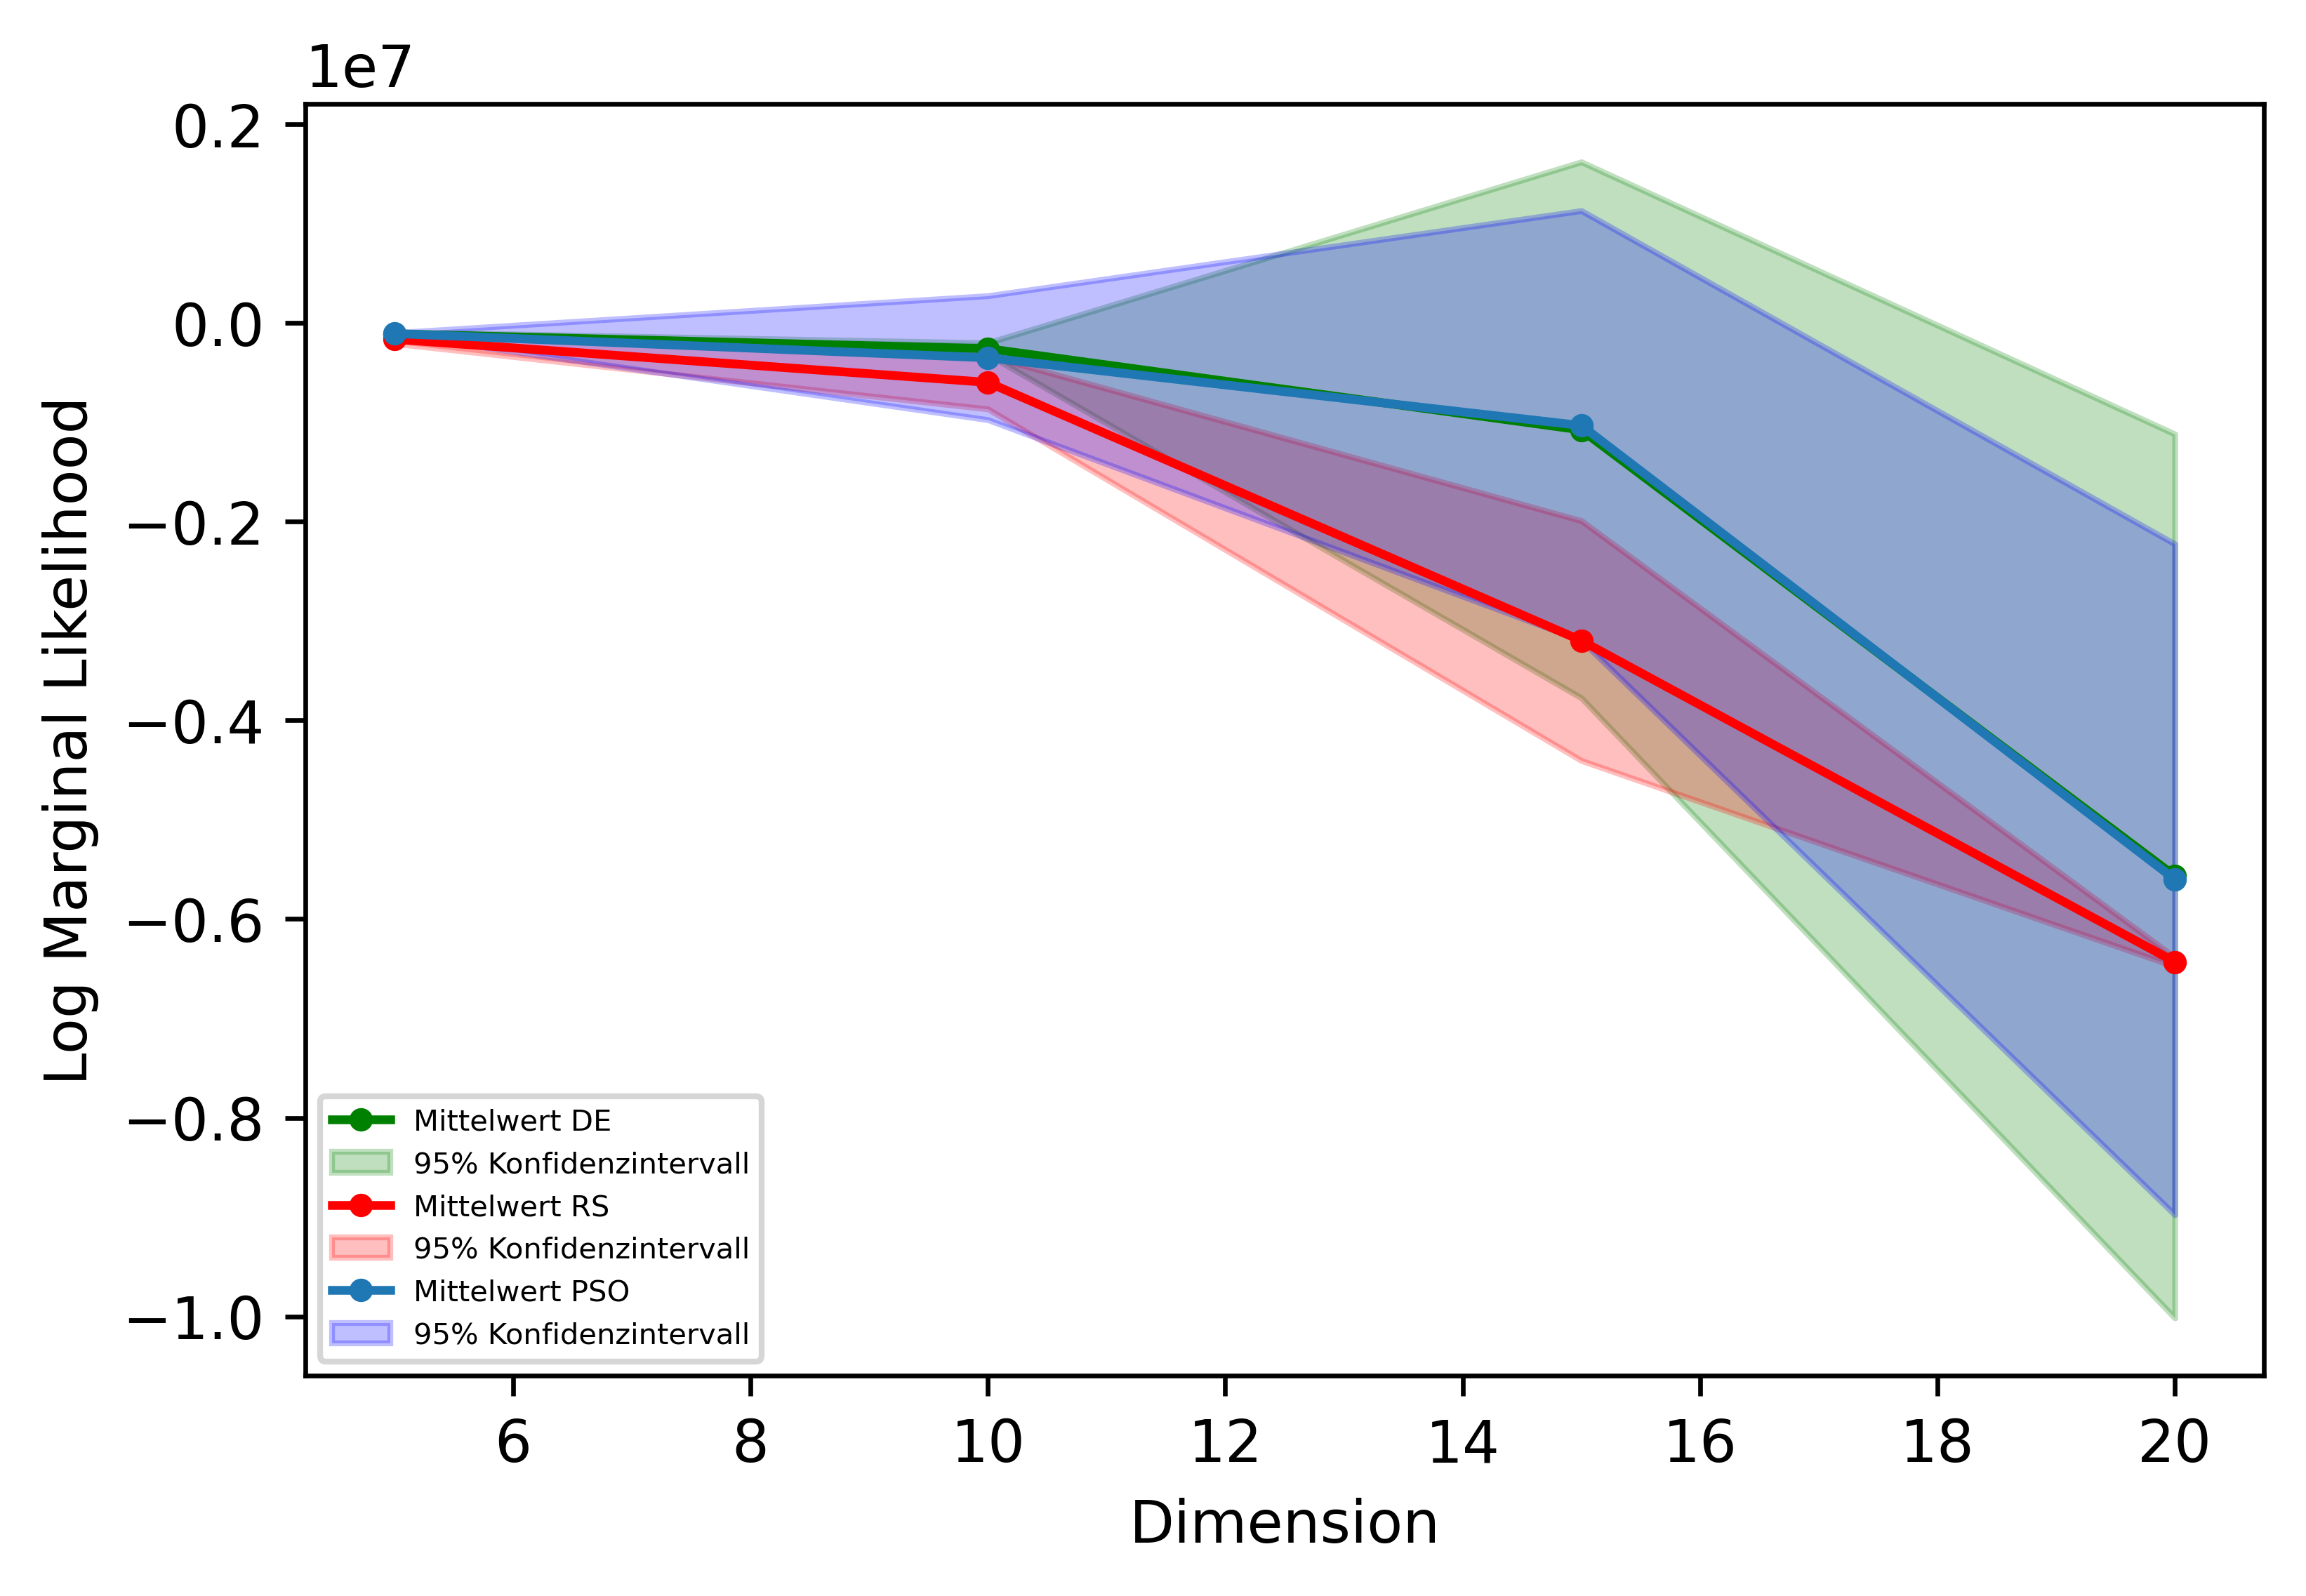

In [24]:
plt.figure(dpi=600)
plt.plot(DE_results["Dimension"], DE_results["Log Likelihood"]["mean"], marker="o", markersize=3, color="g", label="Mittelwert DE")
plt.fill_between(DE_results["Dimension"], DE_results["conf_95_u"], DE_results["conf_95_o"], color="g", alpha=.25, label="95% Konfidenzintervall")

plt.plot(RS_results["Dimension"], RS_results["Log Likelihood"]["mean"], marker="o", markersize=3, color="r", label="Mittelwert RS")
plt.fill_between(RS_results["Dimension"], RS_results["conf_95_u"], RS_results["conf_95_o"], color="r", alpha=.25, label="95% Konfidenzintervall")

plt.plot(PSO_results["Dimension"], PSO_results["Log Likelihood"]["mean"], marker="o", markersize=3, label="Mittelwert PSO")
plt.fill_between(PSO_results["Dimension"], PSO_results["conf_95_u"], PSO_results["conf_95_o"], color="b", alpha=.25, label="95% Konfidenzintervall")

plt.ylabel("Log Marginal Likelihood")
plt.xlabel("Dimension")
plt.legend(fontsize=5, loc='lower left')

In [25]:
dimension_df = pd.read_csv('EvaluationData/DimensionData.csv', sep=",")
dimension_df

,Iteration,Dimension,DE_ML,PSO_ML,RS_ML
0,0,5.0,-1.034063e+05,-1.168129e+05,-1.729504e+05
1,0,10.0,-2.426999e+05,-3.073732e+05,-7.161680e+05
2,0,15.0,-3.587482e+06,-6.027284e+05,-3.577498e+06
3,0,20.0,-6.437604e+06,-1.248328e+06,-6.437604e+06
4,1,5.0,-1.022497e+05,-1.167537e+05,-1.538717e+05
...,...,...,...,...,...
75,18,20.0,-6.437604e+06,-4.607159e+06,-6.437239e+06
76,19,5.0,-1.022497e+05,-1.224762e+05,-1.422706e+05
77,19,10.0,-2.359943e+05,-2.458015e+05,-4.282240e+05
78,19,15.0,-4.350106e+05,-5.228630e+05,-3.524013e+06


In [26]:
dimensions = [5, 10, 15, 20]

In [27]:
for d in dimensions:
    de_df = dimension_df.loc[dimension_df['Dimension'] == d]
    mean_df = de_df.mean()
    de_df["DE"] = de_df["DE_ML"] - mean_df["DE_ML"]
    de_df["RS"]  = de_df["RS_ML"] - mean_df["RS_ML"]
    de_df["PSO"] = de_df["PSO_ML"] - mean_df["PSO_ML"]

C:\Users\Pascal\AppData\Local\Temp\ipykernel_10448\1520453432.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_df["DE"] = de_df["DE_ML"] - mean_df["DE_ML"]
C:\Users\Pascal\AppData\Local\Temp\ipykernel_10448\1520453432.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_df["RS"]  = de_df["RS_ML"] - mean_df["RS_ML"]
C:\Users\Pascal\AppData\Local\Temp\ipykernel_10448\1520453432.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [28]:
de_df

,Iteration,Dimension,DE_ML,PSO_ML,RS_ML,DE,RS,PSO
3,0,20.0,-6.437604e+06,-1.248328e+06,-6.437604e+06,-8.749490e+05,-6287.584055,4.136303e+06
7,1,20.0,-6.437604e+06,-6.437604e+06,-6.407277e+06,-8.749490e+05,24039.231499,-1.052973e+06
11,2,20.0,-6.437604e+06,-6.437604e+06,-6.437604e+06,-8.749490e+05,-6287.584055,-1.052973e+06
15,3,20.0,-6.437604e+06,-6.437604e+06,-6.437604e+06,-8.749490e+05,-6287.584055,-1.052973e+06
19,4,20.0,-6.437604e+06,-6.437604e+06,-6.437551e+06,-8.749490e+05,-6233.976386,-1.052973e+06
23,5,20.0,-6.437604e+06,-4.300637e+06,-6.437604e+06,-8.749490e+05,-6287.584055,1.083994e+06
27,6,20.0,-6.437604e+06,-4.348743e+06,-6.437604e+06,-8.749490e+05,-6287.584055,1.035888e+06
31,7,20.0,-6.790120e+05,-6.437604e+06,-6.437604e+06,4.883643e+06,-6287.584055,-1.052973e+06
35,8,20.0,-6.437604e+06,-6.437604e+06,-6.437604e+06,-8.749490e+05,-6287.584055,-1.052973e+06
39,9,20.0,-6.437604e+06,-6.437604e+06,-6.437604e+06,-8.749490e+05,-6287.584055,-1.052973e+06


In [29]:
PROPS = {'boxprops':{'facecolor': "white", 'edgecolor':'black'},
'medianprops':{'color':'orange'},
'whiskerprops':{'color':'black'},
'capprops':{'color':'black'}
}

i=0
label = ["DE", "RS", "PSO"]
plt.figure(figsize=(25,4), dpi=400)
for f in label:
    i+=1
    if i != 0:
            plt.subplot(1,4,i+1, sharey=ax)
    else:
            plt.subplot(1,4,i+1)
    ax = sns.boxplot(data=de_df[f], color="white", linewidth=1.2, flierprops = dict(markerfacecolor='black', markersize=8,
                  markeredgecolor='none'), **PROPS)
   
    plt.title(f'${f}$')


NameError: name 'ax' is not defined

<Figure size 10000x1600 with 0 Axes>

KeyError: 0

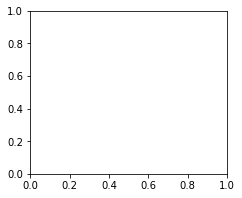

In [30]:

PROPS = {'boxprops':{'facecolor': "white", 'edgecolor':'black'},
'medianprops':{'color':'orange'},
'whiskerprops':{'color':'black'},
'capprops':{'color':'black'}
}

label = ["DE", "RS", "PSO"]
plt.figure(figsize=(12,3))
i = 0
for column in label:
        i+=1
        if i != 1:
                plt.subplot(1,3,i, sharey=ax)
        else:
                plt.subplot(1,3,i)

        ax = sns.boxplot(data=de_df[column], color="white", linewidth=1.2, flierprops = dict(markerfacecolor='black', markersize=8,
                  markeredgecolor='none'), **PROPS)
        plt.title(f'${column}$')
plt.tight_layout()


In [ ]:
de_df["DE_ML_results"]

0      4036.614202
4      5193.155230
8      4036.614202
12     5193.155230
16     1663.869711
20     1328.252492
24     5193.155230
28     5193.155230
32     1328.252492
36   -10375.438927
40   -10440.376687
44   -19874.008617
48     1328.252492
52     5193.155230
56    -5281.917726
60     5193.155230
64    -7429.939667
68     1663.869709
72     1663.869711
76     5193.155230
Name: DE_ML_results, dtype: float64

In [ ]:

sns.boxplot(de_df["DE_ML_results"])
sns.boxplot(de_df["RS_ML_results"])
sns.boxplot(de_df["PSO_ML_results"])


TypeError: subplot() takes 1 or 3 positional arguments but 2 were given

<Figure size 432x288 with 0 Axes>